In [18]:

import sys
import pandas as pd
from cplex import Cplex 
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML

In [2]:
from cplex.callbacks import SimplexCallback
import matplotlib.pyplot as plt

objective_val = []

class MyCallBack(SimplexCallback):
    def __call__(self):
        #capture the current objective values at each iteration
        obj_val = self.get_objective_value()
        objective_val.append(obj_val)

In [3]:
#product information and overall constrainsts 
file_path = 'shipment_test.xlsx'
df = pd.read_excel(file_path, engine = 'openpyxl')

In [4]:
products_dict = df.set_index('Code').T.to_dict()

budget_c = 50000 # Total financial budget
cbm_c = 33 # Total cbm of a 20' container
weight_c = 28 # Total weight in tonne of a 20'container

In [5]:
#Initialize Cplex problem 
problem = Cplex()

problem.set_log_stream(sys.stdout)
problem.set_results_stream(sys.stdout)
problem.set_warning_stream(sys.stdout)
problem.set_error_stream(sys.stdout)
problem.set_problem_type(Cplex.problem_type.LP)

In [6]:
#Set object to maximize profit
problem.objective.set_sense(problem.objective.sense.maximize)

In [7]:
#decision variables
product_ids = list(products_dict.keys())
variable_names = [f"x_{pid}" for pid in product_ids]
profits = [products_dict[pid]['Profit/unit'] for pid in product_ids]

In [8]:
#Variables with bounds
lb = [products_dict[pid]['MOQ/unit'] for pid in product_ids] #lower bound for MOQ
ub = [float('inf') for _ in product_ids] #No upper bound, N/A for our case since already under constriants

In [9]:
#Load up the problem
problem.variables.add(obj=profits, lb=lb, ub=ub, names=variable_names)

range(0, 3)

In [10]:
#Overall constraints

#1: Financial budgets
prices = [products_dict[pid]['Price/unit'] for pid in product_ids]
problem.linear_constraints.add(
    lin_expr=[[variable_names, prices]],
    senses=['L'],
    rhs=[budget_c],
    names=["Budget_Constraint"])

#2: CBM constraints
cbms = [products_dict[pid]['CBM/unit'] for pid in product_ids]
problem.linear_constraints.add(
    lin_expr=[[variable_names, cbms]],
    senses = ['L'],
    rhs=[cbm_c],
    names=["CBM_Constraint"])

#3: Weight constraints
weights = [products_dict[pid]['Weight/unit'] for pid in product_ids]
problem.linear_constraints.add(
    lin_expr=[[variable_names, weights]],
    senses = ['L'],
    rhs=[weight_c],
    names=["Weight_Constraints"])

range(2, 3)

In [11]:
problem.register_callback(MyCallBack)

Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Using devex.


<IPython.core.display.Javascript object>


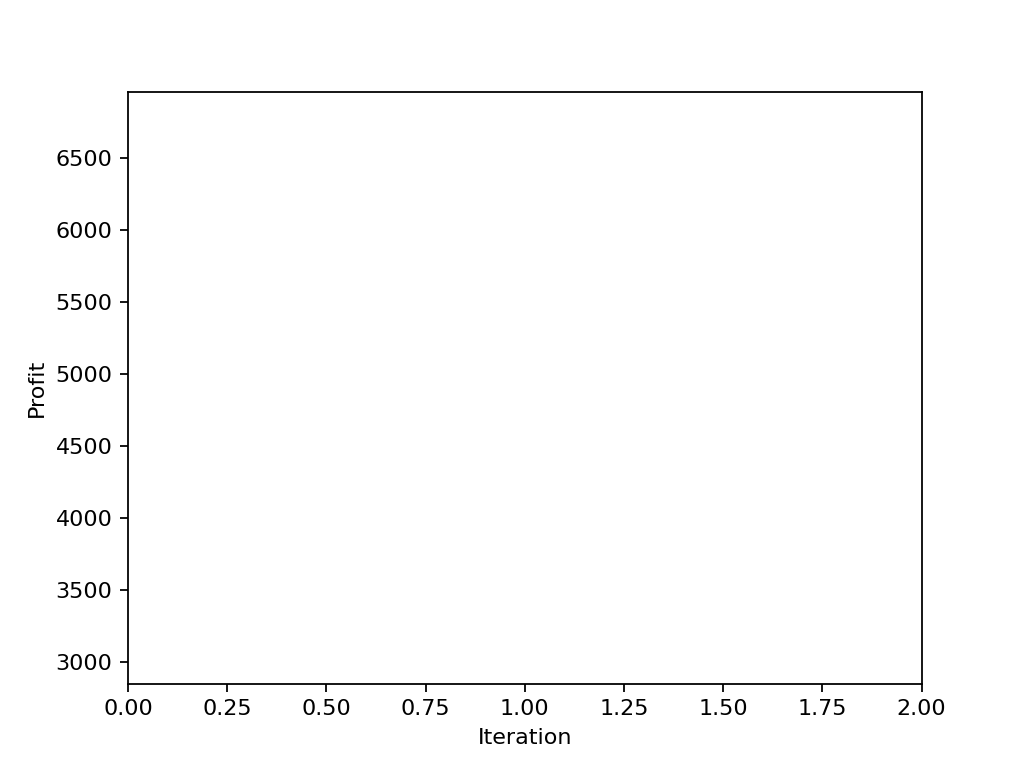

In [19]:
#solve the problem
problem.solve()

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, len(objective_val))
ax.set_ylim(min(objective_val),max(objective_val) + 5)
ax.set_xlabel('Iteration')
ax.set_ylabel('Profit')

def init():
    line.set_data([],[])
    return (line,)

def animate(i):
    x = np.arange(i)
    y = objective_val[:i]
    line.set_data(x,y)
    return (line,)

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(objective_val), interval=200, blit = True)


#plot the progress of objective value
# plt.plot(objective_val)
# plt.xlabel('Iteration')
# plt.ylabel('Profit')
# plt.show()
HTML(ani.to_jshtml())

In [13]:
#Get and display results
solution_val = problem.solution.get_values()
total_profit = problem.solution.get_objective_value()

In [14]:
print("Solution:")
for pid,val in zip(product_ids, solution_val):
    print(f"Product {pid}: {val} units")

print(f"Total Profit: {total_profit}")

Solution:
Product GH01: 600.0 units
Product GH02: 2313.4020618556706 units
Product GH03: 1152.5773195876288 units
Total Profit: 6951.5463917525785
